# 1. 데이터 확인

## 1.1 데이터 분포 확인

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

def show_distribution_info(train_dir, test_dir, val_dir):    
    train_normal = len(glob(train_dir + "NORMAL/*"))
    train_pneumonia = len(glob(train_dir + "PNEUMONIA/*"))
    print(f'train : {train_normal + train_pneumonia}')
    
    test_normal = len(glob(test_dir + "NORMAL/*"))
    test_pneumonia = len(glob(test_dir + "PNEUMONIA/*"))
    print(f'test : {test_normal + test_pneumonia}')
    
    val_normal = len(glob(val_dir + "NORMAL/*"))
    val_pneumonia = len(glob(val_dir + "PNEUMONIA/*"))
    print(f'test : {val_normal + val_pneumonia}')
    
    
    data = [
        {'Normal': train_normal, 'Pneumonia': train_pneumonia },
        {'Normal': test_normal, 'Pneumonia': test_pneumonia },
        {'Normal': val_normal, 'Pneumonia': val_pneumonia }
    ]

    df = pd.DataFrame(
        data, 
        index=['train', 'test', 'validation'],
        columns=['Normal', 'Pneumonia'])
    
    
    df.plot(kind='bar')

train : 5216
test : 624
test : 16


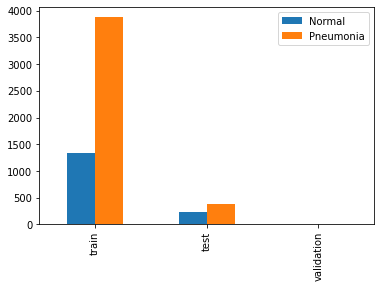

In [2]:
base_dir = "./data/chest_xray/"

train_dir = f'{base_dir}/train/'
test_dir = f'{base_dir}/test/'
val_dir = f'{base_dir}/val/'

show_distribution_info(train_dir, test_dir, val_dir)

In [3]:
Normal = glob(train_dir + "NORMAL/*") + glob(test_dir + "NORMAL/*") + glob(val_dir + "NORMAL/*")
Pneumonia = glob(train_dir + "PNEUMONIA/*") + glob(test_dir + "PNEUMONIA/*") + glob(val_dir + "PNEUMONIA/*")

print(f'Normal : {len(Normal)}')
print(f'Pneumonia : {len(Pneumonia)}')

Normal : 1583
Pneumonia : 4273


## 1.2 데이터 시각화

In [4]:
def show_imgs(imgs):
    plt.figure(figsize=(10,8))

    for i in range(3):
        plt.subplot(3, 3, i + 1)
        img = plt.imread(imgs[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.tight_layout()

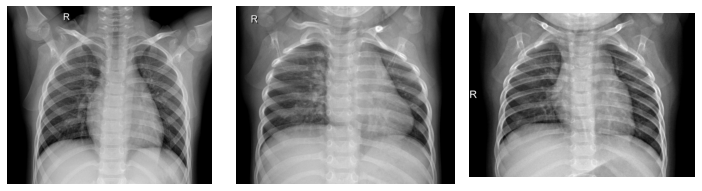

In [5]:
show_imgs([Normal[i] for i in range(3)])

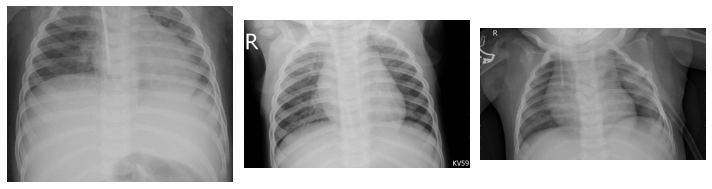

In [6]:
show_imgs([Pneumonia[i] for i in range(3)])

# 2. 데이터 전처리

## 2.1 데이터 분포 조정

> 데이터셋의 비율을 train 80%, test 10%, validation 10%로 조정 필요

In [7]:
import os

base_url = './data'

for _type in ['train', 'test', 'val']:
    os.mkdir(f'{base_url}/{_type}')
    os.mkdir(f'{base_url}/{_type}/NORMAL')
    os.mkdir(f'{base_url}/{_type}/PNEUMONIA')

In [8]:
round(len(Pneumonia) * 0.8), round(len(Pneumonia) * 0.8) + round(len(Pneumonia) * 0.1)

(3418, 3845)

In [9]:
import shutil

for i in Pneumonia[:3418]:
    shutil.copy(i, f'{base_url}/train/PNEUMONIA/')
    
for i in Pneumonia[3418:3845]:
    shutil.copy(i, f'{base_url}/test/PNEUMONIA/')
    
for i in Pneumonia[3845:]:
    shutil.copy(i, f'{base_url}/val/PNEUMONIA/')

In [10]:
round(len(Normal) * 0.8), round(len(Normal) * 0.8) + round(len(Normal) * 0.1)

(1266, 1424)

In [11]:
for i in Normal[:1266]:
    shutil.copy(i, f'{base_url}/train/NORMAL/')
    
for i in Normal[1266:1424]:
    shutil.copy(i, f'{base_url}/test/NORMAL/')
    
for i in Normal[1424:]:
    shutil.copy(i, f'{base_url}/val/NORMAL/')

train : 4684
test : 585
test : 587


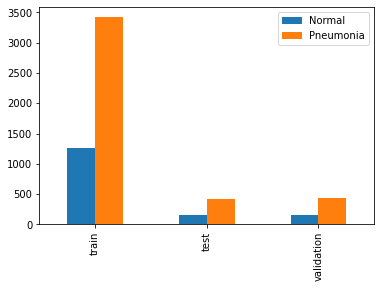

In [12]:
base_dir = './data'

train_dir = f'{base_dir}/train/'
test_dir = f'{base_dir}/test/'
val_dir = f'{base_dir}/val/'

show_distribution_info(train_dir, test_dir, val_dir)

## 2.2 Augmentation

In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=30,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
batch_size = 16

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(224, 224), 
                                                 batch_size=batch_size, 
                                                 class_mode="binary")
val_set = val_datagen.flow_from_directory(val_dir,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          class_mode='binary')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='binary')

Found 4684 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


# 3. 모델 설계

## 3.1 사전 학습된 모델 - DenseNet 121

In [15]:
def dense_block(x, blocks, name):
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

In [16]:
from keras.layers import BatchNormalization, Activation, Conv2D, AveragePooling2D
from keras import backend as K

def transition_block(x, reduction, name):
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(K.int_shape(x)[bn_axis] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

In [17]:
from keras.layers import Concatenate

def conv_block(x, growth_rate, name):
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

In [18]:
from keras.layers import Input, ZeroPadding2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model

def DenseNet(img_input):
    
    blocks = [6, 12, 24, 16]
    bn_axis = 3 if K.image_data_format() == 'channels_last' else 1
    
    x = ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
    x = Activation('relu', name='conv1/relu')(x)
    x = ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = MaxPooling2D(3, strides=2, name='pool1')(x)
    
    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks[3], name='conv5')
    
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)
    
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    
    return Model(img_input, x, name='densenet121')

In [19]:
import tensorflow as tf
from keras.layers import Input

img_input = Input(shape=(224, 224, 3))

DENSENET_WEIGTHS_PATH = (
    'https://github.com/keras-team/keras-applications/'
    'releases/download/densenet/'
    'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')

base_model = DenseNet(img_input)

weights_path = tf.keras.utils.get_file(
    'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
    DENSENET_WEIGTHS_PATH,
    cache_subdir='models',
    file_hash='30ee3e1110167f948a6b9946edeeb738')

base_model.load_weights(weights_path)

## 3.2 사전학습된 모델에 분류기 추가

In [20]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense

x = base_model.output
x = Dense(64, activation='sigmoid', name='fc32')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid', name='fc1')(x)

model = Model(img_input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

# 4. 모델 학습

In [22]:
from keras.callbacks import ReduceLROnPlateau, TensorBoard

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
tb = TensorBoard(log_dir='./logs', histogram_freq=1, embeddings_freq=1)

history = model.fit(
    training_set,
    steps_per_epoch=training_set.samples // batch_size,
    validation_data=val_set,
    epochs=20,
    validation_steps=val_set.samples // batch_size,
    callbacks = [reduce_lr, tb])

Epoch 1/20
292/292 [==============================] - 127s 400ms/step - loss: 0.2272 - accuracy: 0.9098 - val_loss: 0.9478 - val_accuracy: 0.6337
Epoch 2/20
292/292 [==============================] - 111s 379ms/step - loss: 0.1939 - accuracy: 0.9214 - val_loss: 1.1312 - val_accuracy: 0.7257
Epoch 3/20
292/292 [==============================] - 110s 378ms/step - loss: 0.1670 - accuracy: 0.9366 - val_loss: 0.2729 - val_accuracy: 0.9080
Epoch 4/20
292/292 [==============================] - 111s 379ms/step - loss: 0.1501 - accuracy: 0.9437 - val_loss: 0.6881 - val_accuracy: 0.6493
Epoch 5/20
292/292 [==============================] - 111s 378ms/step - loss: 0.1580 - accuracy: 0.9392 - val_loss: 0.8178 - val_accuracy: 0.8003

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/20
292/292 [==============================] - 110s 378ms/step - loss: 0.1135 - accuracy: 0.9533 - val_loss: 0.5691 - val_accuracy: 0.7535
Epoch 7/20
292/292 [=======================

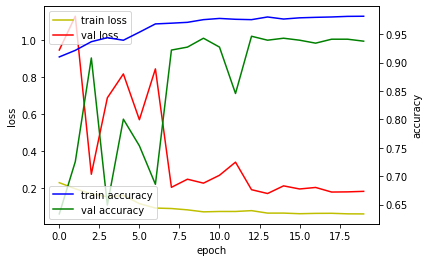

In [23]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

# 5. 평가

In [24]:
print(f'Accuracy: {model.evaluate(test_set)[1]*100}%')

37/37 [==============================] - 8s 203ms/step - loss: 0.3212 - accuracy: 0.9043
Accuracy: 90.4273509979248%


## 5.1 Classification Report

In [36]:
import numpy as np

pred = model.predict(test_set, batch_size=16)

from sklearn.metrics import classification_report
print(classification_report(test_set.classes, pred.round()))

              precision    recall  f1-score   support

           0       0.29      0.36      0.32       158
           1       0.74      0.68      0.71       427

    accuracy                           0.59       585
   macro avg       0.52      0.52      0.52       585
weighted avg       0.62      0.59      0.61       585



## 5.2 CAM

In [76]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, heatmap, alpha=0.4):
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    
    jet = cm.get_cmap("jet")
    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

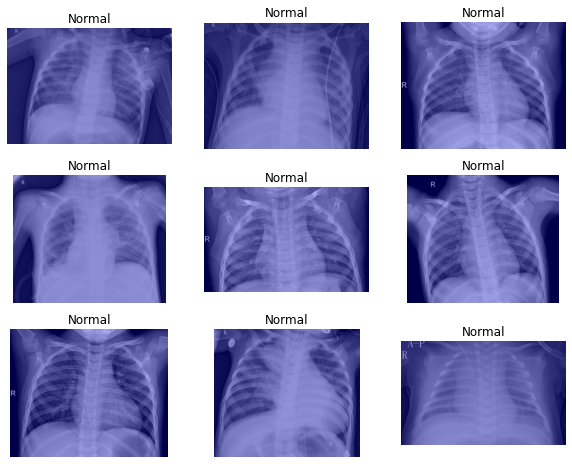

In [84]:
import cv2

last_conv_layer_name = 'conv5_block16_2_conv'

imageset = glob(test_dir + "*/*")
random_images = [np.random.choice(imageset) for i in range(9)]

plt.figure(figsize=(10,8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = random_images[i]
    img = get_img_array(img_path, (224, 224))
    preds = model.predict(img)

    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
    simg = display_gradcam(img_path, heatmap)
    
    if (preds[0] < 0.5):
        plt.title("Normal")
    
    else:
        plt.title("Pneumonia")
        
    plt.imshow(simg)
    plt.axis('off')
        
plt.show()